In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
anime_df = pd.read_csv("/content/drive/My Drive/anime_data/anime.csv")
anime_df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [ ]:
import pandas as pd
rating_df = pd.read_csv("/content/drive/My Drive/anime_data/rating.csv")
rating_df

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


top10 popular anime:
                                    name  weighted_rating
1997                         Steins;Gate         8.074834
1569    Fullmetal Alchemist: Brotherhood         7.989009
3314                      Kimi no Na wa.         7.865382
2238              Hunter x Hunter (2011)         7.814615
1462                Clannad: After Story         7.783129
1269  Code Geass: Hangyaku no Lelouch R2         7.728091
1088          Tengen Toppa Gurren Lagann         7.662938
2931             Shigatsu wa Kimi no Uso         7.645272
9                                Monster         7.615327
944      Code Geass: Hangyaku no Lelouch         7.609182


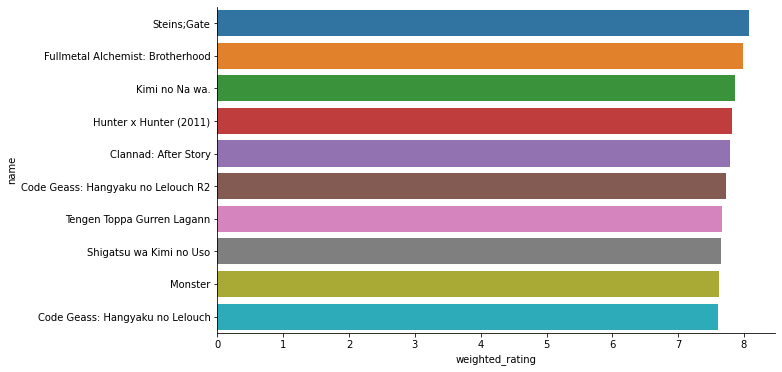

In [ ]:
# %matplotlib inline

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def weighted_rating(v,m,R,C):
    '''
    Calculate the weighted rating
    
    Args:
    v -> average rating for each item (float)
    m -> minimum votes required to be classified as popular (float)
    R -> average rating for the item (pd.Series)
    C -> average rating for the whole dataset (pd.Series)
    
    Returns:
    pd.Series
    '''
    return ( (v / (v + m)) * R) + ( (m / (v + m)) * C )

def assign_popular_based_score(rating_df, item_df, user_col, item_col, rating_col):
    '''
    Assigned popular based score based on the anime weighted average.
    
    Args:
    rating -> pd.DataFrame contains ['item_id', 'rating'] for each user.
    
    Returns
    popular_items -> pd.DataFrame contains item and IMDB weighted score.
    '''
    
    # pre processing
    vote_count = (
        rating_df
        .groupby(item_col,as_index=False)
        .agg( {user_col:'count', rating_col:'mean'} )
        )
    vote_count.columns = [item_col, 'vote_count', 'avg_rating']
    # print(vote_count)

    # calcuate input parameters
    C = np.mean(vote_count['avg_rating'])
    m = np.percentile(vote_count['vote_count'], 70)
    vote_count = vote_count[vote_count['vote_count'] >= m]
    R = vote_count['avg_rating']
    v = vote_count['vote_count']
    vote_count['weighted_rating'] = weighted_rating(v,m,R,C)
    
    # post processing
    vote_count = vote_count.merge(item_df, on = [item_col], how = 'left')
    popular_items = vote_count.loc[:,[item_col, 'name', 'vote_count', 'avg_rating', 'weighted_rating']]
    
    return popular_items

# init constant
USER_COL = 'user_id'
ITEM_COL = 'anime_id'
RATING_COL = 'rating'

# calcualte popularity based
pop_items = assign_popular_based_score(rating_df, anime_df, USER_COL, ITEM_COL, RATING_COL)
# print(pop_items)
sorted_pop_items = pop_items.sort_values('weighted_rating', ascending = False)
# print(sorted_pop_items.head(10))
top10_popular = sorted_pop_items.loc[:,['name', 'weighted_rating']].head(10)
print("top10 popular anime:")
print(top10_popular)

# # plot the popularity based on the weighted score
fix, ax = plt.subplots(figsize=(10,6))
sns.barplot(data = top10_popular.head(10),
            y = 'name',
            x = 'weighted_rating');
sns.despine();